## ResNet (TensorFlow Implementation)
https://arxiv.org/abs/1512.03385

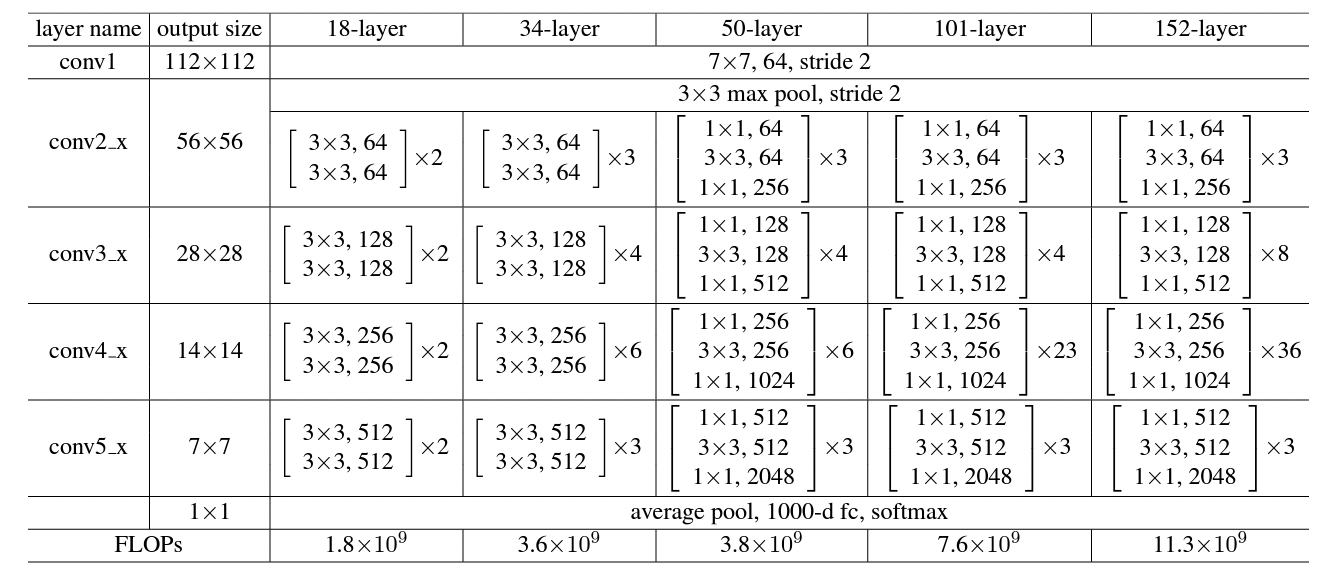

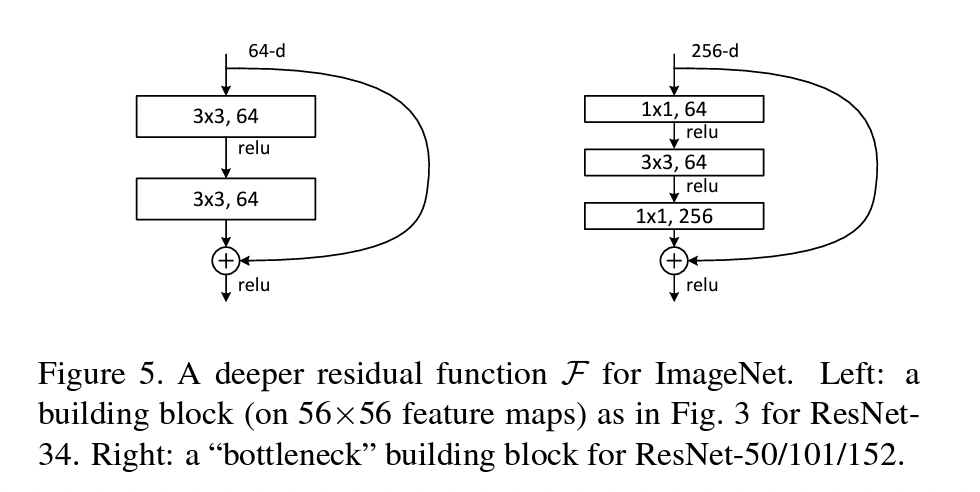